# PCA 
_Principle Component Analysis_ is one of the most famous dimensionality reduction technique, it searches for the closest hyperplane to the data points and then projects them on it.

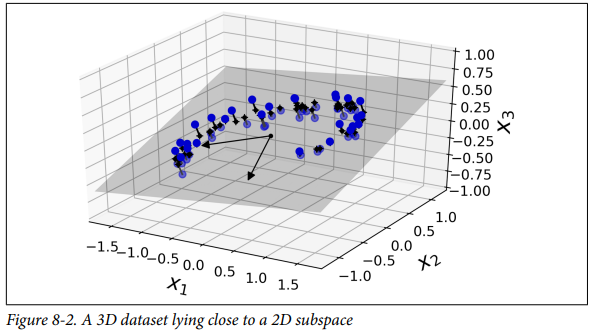

### _Preserving the variance_
What exactly is the right hyperplane that we need for projection?  
A hyperplane which loses minimum information right... In PCA, information is measured in terms of variance. 
- That means, in PCA we look for a hyperplane that preserves maximum variance in the dataset.
- Another way to see this is as, we want hyperplane that minimizes the squared distances between data points and their projection.

example below: (on the left) is a 2D dataset with three 1D planes, we can see on the right that solid line preseves good amount of variance and other two planes does not. 

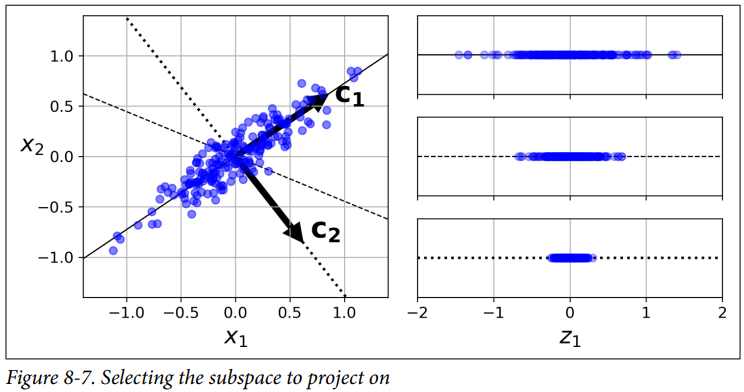

## _Principle Components_
The PCA, does not only find a single axis (direction), the first axis accounts for largest variance, the second axis (othogonal to first) accounts for remaining largest variance and so on...
- In short,PCA tries to find as many axis as the number of dimensions all orthogonal to each other.  
- The $i^{th}$ _axis_ is called $i^{th}$ _principle component_ of the data

___Note___   
For each principle component, PCA finds _zero-centered unit vector_ (unit vector starting from origin), and since there exists two unit vectors in an axis, the direction of unit vectors returned by PCA are not stable and may change as we run code again. However, they will still lie on same axis.

___How you find principle components then?___   
There is a matrix factorization technique called _Singular Value Decomposition_ which decomposes the matrix $X$ into multiplication of three matrices $U \Sigma V^T$ where   
$U$ is mxm matrix  
$\Sigma$ is mxn matrix  
$V$ is nxn matrix  (This is what we need, unit vectors that define all principle components)   

Basically, $X = U \Sigma V^T$

$$
\mathbf{V} =
\begin{pmatrix}
\; | & | &  & | \; \\
\mathbf{c}_1 & \mathbf{c}_2 & \cdots & \mathbf{c}_n \\
\; | & | &  & | \; 
\end{pmatrix}
$$

where c1, c2,...,cn are unit vectors  
Note: But the svd() function returns U, s and V⊺ instead. s is the vector containing all the values on the main diagonal of the top n rows of Σ.


In [1]:
# Below is an example to find PCs using svd() function of numpy

In [2]:
# Extra code 
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

Note- PCA assumes that data is centered around the origin. sklearn pca classes will handle it by themselves tho

In [3]:
X_centered = X - X.mean(axis=0)
U,s,Vt = np.linalg.svd(X_centered)
print(Vt)
##Got 3 unit vectors (as rows columns)

[[ 0.67857588  0.70073508  0.22023881]
 [-0.72817329  0.6811147   0.07646185]
 [-0.09642839 -0.21225719  0.97244458]]


In [4]:
for i in range(3):
    print(f"c{i+1} = {Vt[i,:]}")

c1 = [0.67857588 0.70073508 0.22023881]
c2 = [-0.72817329  0.6811147   0.07646185]
c3 = [-0.09642839 -0.21225719  0.97244458]


In [5]:
# Their magnitude is 1 
for i in Vt:
    unit = sum(i**2)
    print(unit)

0.9999999999999999
0.9999999999999998
0.9999999999999999


## _Reducing dimensionality to d-dimensions_
After we got our principle components, we can reduce the dimensionality of training data by taking its projection on hyperplane defined by first _d_ principle components.


See the arrows in example below, they define the hyperplane and then we project all data points on that.

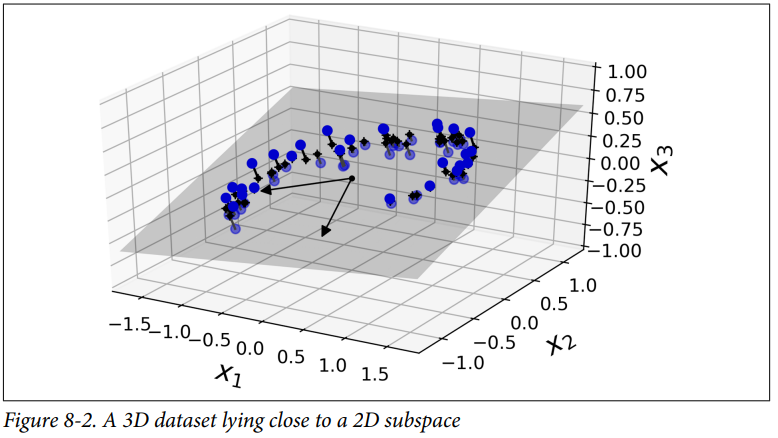

Mathematicaly, it is done by matrix multiplication: 
$$
X_{d-proj} = XW_d
$$

where:   
- X_{d-proj} is the new d-dimension data
- $X$ is centered training data matrix of n-dimensions (n>d) 
- $W_d$ is matrix containing d-columns of $V$ (or d-rows of $V^T)$ (first d PCs)

In [6]:
#Reducing the above data into 2D
Wd = Vt.T[:,:2]
X_dproj = X_centered @ Wd
print('original:',X.shape)
print('reduced:',X_dproj.shape)

original: (60, 3)
reduced: (60, 2)


In [7]:
Wd

array([[ 0.67857588, -0.72817329],
       [ 0.70073508,  0.6811147 ],
       [ 0.22023881,  0.07646185]])

### PCA Using sklearn

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_dproj = pca.fit_transform(X)   #It takes care of centering the data

___components___

In [9]:
# components_ holds the transpose of Wd
pca.components_

array([[ 0.67857588,  0.70073508,  0.22023881],
       [ 0.72817329, -0.6811147 , -0.07646185]])

___Explained Variance Ratio___   
This gives the ratio of variance that each principle component hold

In [10]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

That means 75% of variance lies along first PC and 15% along second PC, this leaves less than 10% variance along third PC, hence third pc holds least amount of info.  
And since we reduced dimensions to 2D

In [11]:
1 - pca.explained_variance_ratio_.sum()

np.float64(0.09028309326742034)

__We lost about 9% of information (variance)__

### _Choosing the right number of dimensions_
Rather than selecting dimensions by ourselves. We should select dimensions based on a threshold of variance to be preserved.  
Ex: we need dimensions that preserve variance by 95% 

In [12]:
#Getting the data
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version=1,as_frame=False,parser='auto')
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [13]:
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [14]:
# Method 1: Find the right number of dimension then train PCA again 
pca = PCA()  
pca.fit(X_train)

sum = np.cumsum(pca.explained_variance_ratio_) #cumsum returns a list of cumulative summations
d = np.argmax(sum>=0.95) + 1                   #argmax returns the index at which maximum value is occured first

print(d)

154


In [15]:
pca = PCA(n_components=d)
X_d = pca.fit_transform(X_train)
X_d.shape

(60000, 154)

In [16]:
# Method 2: If we give float from 0-1 as n_components, it automatically selects the dimensions to preserve 95% variance
pca = PCA(n_components=0.95)
X_d = pca.fit_transform(X_train)
X_d.shape

(60000, 154)

In [17]:
# Method 3: plot cumulative
import matplotlib.pyplot as plt

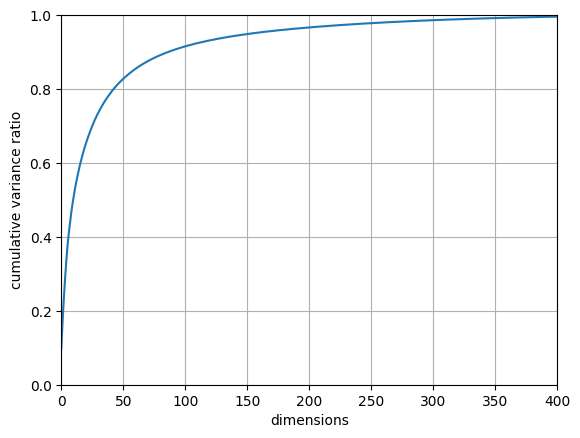

In [18]:
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)


plt.xlabel("dimensions")
plt.ylabel('cumulative variance ratio')
plt.axis([0,400,0,1])
plt.plot(cumulative_variance)
plt.grid(True)

from here we can see that after about 150-200 dimensions we are not gaining much variance

### _PCA for compression_ 
PCA can also be used for compression of data. We can reduce the size of data for compression and reconstruct the data again by using inverse transform of reduced data. 

In [19]:
pca = PCA(n_components=154)     #Reducing the size from 784 features to 154
X_reduced = pca.fit_transform(X_train)
X_reconstruct = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'reconstructed')

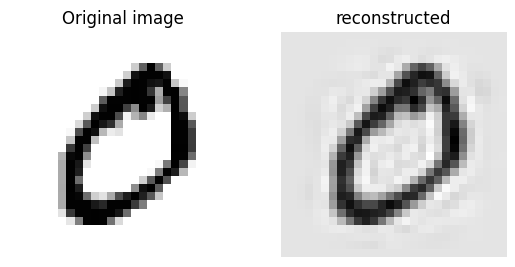

In [20]:
# Plotting the images 

plt.subplot(1,2,1)
plt.imshow(X_train[1,:].reshape(28,28),cmap='binary')
plt.axis('off')
plt.title('Original image')

# Note: we cannot directly visualise reduced image since we dont know its dimensions.

plt.subplot(1,2,2)
plt.imshow(X_reconstruct[1,:].reshape(28,28),cmap='binary')
plt.axis('off')
plt.title('reconstructed')

Equation used for inverse transformation
$$
X_{recovered} = X_{d-proj}W_d^T
$$

### _Computational Complexity_

- The full svd approach have complexity of $O(m \times n^2) + O(n^3)$
- In sklearn, if we do `svd_solver = randomized`,a stochastic algorithm called _Randomized PCA_ that quickly finds an approximation of the first d principal components, the time complexity reduces significantly to $O(m \times d^2) + O(d^3)$
- But in general keep it, as `auto`

In [21]:
from time import time
t = time()
rnd_pca = PCA(n_components=154, svd_solver="full")
X_reduced = rnd_pca.fit_transform(X_train)
print(time()-t)

5.820621490478516


In [22]:
t = time()
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)
print(time()-t)

3.285900354385376


In [23]:
t = time()
rnd_pca = PCA(n_components=154, svd_solver="auto")
X_reduced = rnd_pca.fit_transform(X_train)
print(time()-t)

0.6991329193115234


### _Incremental PCA (IPCA)_
Normal PCA need the whole data to be feeded at once, this is not possible for large datasets. Thats when incremental PCA comes into the game. With this we can reduce the dimension of data on the fly (supports online learning).

It splits the data into mini batches and allow you to feed the data to PCA one mini batch at a time

In [24]:
from sklearn.decomposition import IncrementalPCA
#Splitting the dataset into batches of 100 isntances and training IPCA

batch = 100   #Number of batches
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train,batch):    #Split the data into 100 batches
    inc_pca.partial_fit(X_batch)                 #Do partial_fit to train on each batch sequentially

X_reduced = inc_pca.transform(X_train)

Remember to use __partial_fit__ and not fit 

In [25]:
# I can do the same without using loop
batch_size = len(X_train) // batch 
inc_pca = IncrementalPCA(n_components=154,batch_size=batch_size)

X_reduced = inc_pca.fit(X_train)   #fit is just a wrapper around partial_fit here,
#internally it splits data into required chunks and call partial_fit on each one of them 

# But this kills the fact that i do not have enough RAM for large datasets everytime

Another way of using incremental pca is by using `memmap` class of numpy.   
- _memmap_ or _memory mapping_ creates an object that looks like numpy.array but is actually backed by a file on the _disk_.   
- The cool part is that, it only loads the data that it needs in the memory (RAM), when it _needs_ it.
- This way, only a small part of data is in the memory at a time which keeps memory under control

In [26]:
filename = 'mnist.mmap'  #Give filename
X_mmap = np.memmap(filename=filename,dtype='float32',mode='write',shape=(len(X_train),784))
X_mmap[:]=X_train        #assign all training instances, this could be a loop and data be given chunk by chunk
X_mmap.flush()           #flush() makes sure that all cache have been saved on the disk 

In [27]:
## Load the data and use it for training
X_mmap = np.memmap(filename=filename,dtype='float32',mode='readonly').reshape(-1,784)
inc_pca = IncrementalPCA(n_components=154,batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

### _Kernel PCA (kPCA)_
- __Problem with normal PCA__  
Simple PCA projects the data perpendicularly on the hyperplane decided by principle components that preserves maximum variance.   
But this is a linear approach. If the data lies on non-linear manifold (like spiral,circle), Simple PCA cannot unfold it.  


- We have learnt about similarity features in svms - a mathematical technique in which we map each training instance to a very high dimension space called _feature space_. A simple linear decision boundary in that feature space can be a complex non-linear decision boundary in original dimensions

- The same trick can be applied to PCA, We will project the data on a very high dimension feature space and then use PCA to find a hyperplane, that linear hyperplane will be non-linear in original dimension space. This is called _Kernel PCA_
It is often good at preserving clusters of instances after projection, or
sometimes even unrolling datasets that lie close to a twisted manifold.

In [34]:
#Get swiss roll dataset
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
y = t > 6.9  #We will use examples of classification, since t is continuous i will use y

In [32]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(n_components=2,kernel='rbf',gamma=0.04)
X_reduced = kpca.fit_transform(X) 

#run it with very low instances cuz ts will kill your ram and freez tf outta laptop

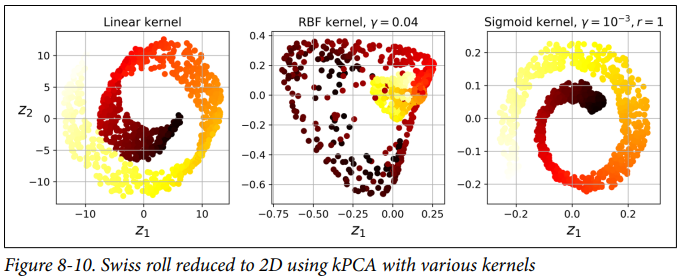

# Have to resume from here again in some time!!

### Kernel selection and hyperparameter tuning
kPCA is a unsupervised learning algorithm, there is no obvious performance measure to measure its perfomance. But since, we will use kPCA for preprocessing and then do supervised learning, We can tweak its parameters till we get best perfomance at the end 

Minimizing reconstruction error  
Reconstruction error is mean squared distance between original data points and reconstructed data points.  
By using `fit_inverse_transform=True`  
Then using gridsearch to find best parameters to reduce this error

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


## This is going to take several minutes, use less instances if dont have the time
clf = Pipeline(
    [('kpca',KernelPCA(n_components=2)),
    ('lr',LogisticRegression())]
)

param_grid = [{
    'kpca__gamma': np.linspace(0.03,0.05,10),   #Dont forget double underscore
    'kpca__kernel':['rbf','sigmoid']            #syntax is: stepname__parameter
}]

grid_search = GridSearchCV(clf,param_grid=param_grid,n_jobs=-1,cv=3)
grid_search.fit(X,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [60]:
grid_search.best_params_

{'kpca__gamma': np.float64(0.043333333333333335), 'kpca__kernel': 'rbf'}

- Method 2: Minimizing reconstruction error  
Reconstruction error is mean squared distance between original data points and reconstructed data points.  
By using `fit_inverse_transform=True`  
Then using gridsearch to find best parameters to reduce this error

In [46]:
from sklearn.metrics import mean_squared_error

rbf_pca = KernelPCA(n_components=2,fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_reconstruct = rbf_pca.inverse_transform(X_reduced)

mean_squared_error(X,X_reconstruct)

51.58463490231055

In [49]:
# Minimize this error by finding best parameters
param_grid = [{
    'kernel':['rbf','sigmoid','poly'],
    'gamma':np.linspace(0.01,0.1,20)
}]

def reconstruction_error(estimator,X):
    X_reduced = estimator.transform(X)
    X_reconstruct = estimator.inverse_transform(X_reduced)
    return -mean_squared_error(X,X_reconstruct)   #negative since, GridSearch tries to maximise the score
rbf_pca = KernelPCA(n_components=2,fit_inverse_transform=True)

grid_search_pca = GridSearchCV(estimator=rbf_pca,param_grid=param_grid,
                               n_jobs=-1,cv=3,scoring=reconstruction_error)
grid_search_pca.fit(X,y)

c:\Users\Arun\Documents\Documents\Machine_Learning\venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=KernelPCA(fit_inverse_transform=True, n_components=2),
             n_jobs=-1,
             param_grid=[{'gamma': array([0.01      , 0.01473684, 0.01947368, 0.02421053, 0.02894737,
       0.03368421, 0.03842105, 0.04315789, 0.04789474, 0.05263158,
       0.05736842, 0.06210526, 0.06684211, 0.07157895, 0.07631579,
       0.08105263, 0.08578947, 0.09052632, 0.09526316, 0.1       ]),
                          'kernel': ['rbf', 'sigmoid', 'poly']}],
             scoring=<function reconstruction_error at 0x000001E01B892700>)

In [50]:
grid_search_pca.best_params_

{'gamma': np.float64(0.01), 'kernel': 'rbf'}